# 1: Librerie
Importazione di tutte le librerie necessarie per la gestione del dataset, la costruzione del modello e l'apprendimento della rete.

* `tensorflow`: Funzioni di creazione del modello, e di gestione della fase di training.
* `numpy`: Gestione di array e funzioni di calcolo.
* `pandas`: Funzioni di apertura e parsing del dataset.
* `matplotlib`: Funzioni di gestione dei grafici, per la visualizzazione dei risultati in fase di training.

In [22]:
"""
Install dependencies:
>>> pip install --update pip
>>> pip install numpy pandas matplotlib seaborn scikit-learn tensorflow 
"""

'\nInstall dependencies:\n>>> pip install --update pip\n>>> pip install numpy pandas matplotlib seaborn scikit-learn tensorflow \n'

In [ ]:
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.layers     as layers
import tensorflow.keras.models     as models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks            import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection    import train_test_split
from sklearn.preprocessing      import LabelEncoder as le
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

## Variabili globali
* `num_layers`: Configurazione degli strati della rete. Aggiungendo e rimuovendo neuroni, è possibile modificare la rete.
    * Ogni elemento di `num_layers` dovrebbe essere un array di 3 elementi: numero di neuroni nello strato, funzione di attivazione, larghezza del dropout.
* `num_epochs`: Numero di epoche di training del modello.
* `batch_size`: Larghezza dei batch durante la fase di training.

In [24]:
net_layers = [
    [32, 'relu', 0.2] for _ in range(3)] + [
    [64, 'relu', 0.2] for _ in range(2)] + [
    [32, 'relu', 0.5] for _ in range(3)
]
num_epochs = 20 # Number of epochs
batch_size = 16  # Batch size
#aaa

# 2: Dataset augmentation function


In [25]:
def dataset_augmentation(dataset: pd.DataFrame, target_count = 1000, column_augmentation = ['Age', 'Old']) -> pd.DataFrame:

    col_key     = column_augmentation[0] # key column for filtering
    col_val     = column_augmentation[1] # value to filter by
    old_samples = dataset[dataset[col_key] == col_val].copy() # filter samples
    
    # check if there are any samples to augment
    if len(old_samples) == 0:
        print(f"WARNING: No samples found for {col_val} in column {col_key} for data augmentation.")
        return dataset
    
    # check if the number of samples is already sufficient
    if len(old_samples) >= target_count:
        print(f"WARNING: Number of samples for {col_val} in column {col_key} is already sufficient.")
        return dataset
    
    print(f"Target number of values for {col_val}: {target_count}")
    print(f"Number of samples found: {len(old_samples)}")

    num_cols = old_samples.keys()[1 : -1] # skip first and last column (not numeric features)
    
    synthetic_samples = []
    samples_needed    = target_count - len(old_samples)
    
    for i in range(samples_needed):

        base_sample = old_samples.sample(n = 1).iloc[0].copy() # base sample from 'Old' samples
        
        for col in num_cols: # add noise to numeric columns
            noise_factor     = np.random.uniform(0.02, 0.08)
            noise            = np.random.normal(0, base_sample[col] * noise_factor)
            base_sample[col] = max(0, base_sample[col] + noise) # ensure no negative values
        
        synthetic_samples.append(base_sample) # append modified sample to list
    
    # convert list of synthetic samples to DataFrame
    synthetic_df      = pd.DataFrame(synthetic_samples)
    augmented_dataset = pd.concat([dataset, synthetic_df], ignore_index = True)
    
    print(f"Number of samples after augmentation: {len(augmented_dataset)}")
    
    return augmented_dataset # return augmented dataset with synthetic samples

# 3: Dataset
Importazione del dataset e divisione delle istanze per validation, training e testing.

## Obiettivo del modello
Classificazione dell'età di un *abalone*, a seconda delle misure fisiche effettuate.

* Elementi: **4177** istanze
* Features disponibili: **8** colonne
* Classificazione: **3** classi

In [26]:
try:

  dataset = pd.read_csv("./Dataset.csv") # load the dataset

  dataset['Sex'] = le().fit_transform(dataset['Sex']) # label encoding for column 'Sex'
  
  for val in dataset['Age'].unique(): # Dataset augmentation
    dataset = dataset_augmentation(dataset, target_count = 600, column_augmentation = ['Age', val]) 

  # One-hot encoding for column 'Age'
  column     = 'Age'
  dataset    = pd.get_dummies(dataset, columns = [column], prefix = column)
  dummy_cols = [col for col in dataset.columns if col.startswith(f'{column}_')]

  # Separate features and labels
  Y = dataset[dummy_cols]
  X = dataset.drop(columns = dummy_cols)

  # First split: 70% train, 30% combined validation and test
  X_train, X_combined, Y_train, Y_combined = train_test_split(
    X, Y, test_size = 0.3, random_state = 42)

  # Second split: 50% validation, 50% test from the 30% combined set
  X_val, X_test, Y_val, Y_test = train_test_split(
    X_combined, Y_combined, test_size = 0.5, random_state = 42)

  print("\nTraining set shape:  ", X_train.shape, Y_train.shape)
  print("Validation set shape:", X_val.shape, Y_val.shape)
  print("Test set shape:      ", X_test.shape, Y_test.shape)
except FileNotFoundError:
  print("ERROR: Dataset file not found. Please ensure the file 'Dataset.csv' is in the current directory.")

Target number of values for Old: 600
Number of samples found: 36
Number of samples after augmentation: 4741

Training set shape:   (3318, 8) (3318, 3)
Validation set shape: (711, 8) (711, 3)
Test set shape:       (712, 8) (712, 3)


# 4: Creazione del modello
Generazione di un modello di rete neurale.

In [27]:
model = models.Sequential([layers.Input(shape = (X_train.shape[1],))]) # Input layer

for layer in net_layers: # Add hidden layers
    model.add(layers.Dense(layer[0], activation = layer[1])) # Dense layer
    model.add(layers.Dropout(layer[2])) # Dropout layer to prevent overfitting
    model.add(layers.BatchNormalization()) # Batch normalization layer
    
model.add(layers.Dense(Y_train.shape[1], activation = 'softmax')) # Output layer

model.summary() # Print the model summary

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,243 (55.64 KB)

 Trainable params: 13,603 (53.14 KB)

 Non-trainable params: 640 (2.50 KB)

## 5: Compilazione e training del modello generato

In [ ]:
lr_schedule = ExponentialDecay(
    initial_learning_rate = 1e-4, # Starting learning rate
    decay_steps           = 20e3, # Number of steps before decay
    decay_rate            = 0.96, # Multiplicative decay factor
)

model.compile(
    optimizer = optimizers.Adam(learning_rate = lr_schedule),
    loss      = 'categorical_crossentropy', 
    metrics   = ['accuracy', 'Precision', 'Recall']
)

# early_stop = EarlyStopping(
#     monitor              = 'val_loss',
#     patience             = 10,
#     restore_best_weights = True
# )

# reduce_lr = ReduceLROnPlateau(
#     monitor  = 'val_loss',
#     factor   = 0.5,
#     patience = 5,
#     min_lr   = 0.0001,
#     verbose  = 1
# )

In [29]:
history = model.fit(
    X_train, Y_train,
    epochs          = num_epochs,    # Number of epochs
    batch_size      = batch_size,    # Batch size
    validation_data = (X_val, Y_val)
)

Epoch 1/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - Precision: 0.3133 - Recall: 0.2423 - accuracy: 0.3210 - loss: 1.5978 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.4219 - val_loss: 1.0524
Epoch 2/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Precision: 0.3344 - Recall: 0.2564 - accuracy: 0.3425 - loss: 1.5105 - val_Precision: 0.4286 - val_Recall: 0.1097 - val_accuracy: 0.4515 - val_loss: 1.0206
Epoch 3/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Precision: 0.3793 - Recall: 0.2778 - accuracy: 0.3773 - loss: 1.3735 - val_Precision: 0.4706 - val_Recall: 0.1463 - val_accuracy: 0.4599 - val_loss: 1.0049
Epoch 4/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Precision: 0.3701 - Recall: 0.2760 - accuracy: 0.3699 - loss: 1.3945 - val_Precision: 0.5017 - val_Recall: 0.2068 - val_accuracy: 0.4726 - val_loss: 0.9951
Epoch 5/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Precision: 0.4062 - Recall: 0.2926 - accuracy: 0.3899 - loss: 1.2924 - val_Precision: 0.5021 - val

## 6: Visualizzazione dei risultati

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7106 - Recall: 0.0313 - accuracy: 0.5605 - loss: 0.9539 
Test set evaluation:
Precision: 0.6944
Recall:    0.0351
Loss:      0.9591
Accuracy:  0.5604
F1-score:  0.0668
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


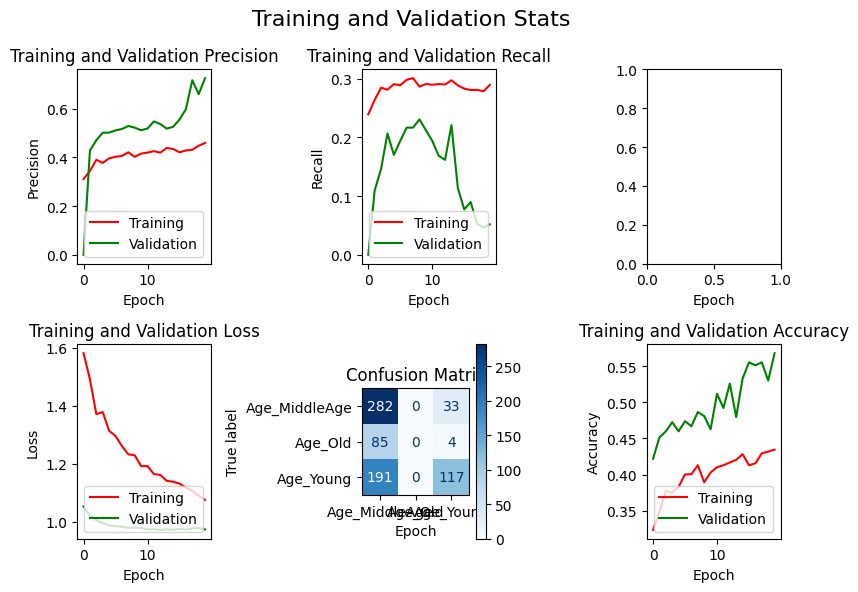

In [ ]:
eval = model.evaluate(X_test, Y_test, return_dict = True) # Evaluate the model on the test set

print("Test set evaluation:")
print(f"Precision: {eval['Precision']:.4f}")
print(f"Recall:    {eval['Recall']:.4f}")
print(f"Loss:      {eval['loss']:.4f}")
print(f"Accuracy:  {eval['accuracy']:.4f}")
print(f"F1-score:  {2 * (eval['Precision'] * eval['Recall']) / (eval['Precision'] + eval['Recall']):.4f}")

fig, plots = plt.subplots(2, 3, figsize = (8, 6)) # Create a figure with 2 subplots
fig.suptitle('Training and Validation Stats', fontsize = 16)

# Training and validation precision
plots[0, 0].set_title('Training and Validation Precision') # Set title for the first subplot
plots[0, 0].plot(history.history['Precision'],     label = 'Training',   color = 'red')   # plot 1
plots[0, 0].plot(history.history['val_Precision'], label = 'Validation', color = 'green') # plot 2
plots[0, 0].set_ylabel('Precision') # Set y-axis label
plots[0, 0].legend(loc = 'lower left') # add legend to the plot in lower left corner

# Training and validation recall
plots[0, 1].set_title('Training and Validation Recall') # Set title for the second subplot
plots[0, 1].plot(history.history['Recall'],     label = 'Training',   color = 'red')   # plot 1
plots[0, 1].plot(history.history['val_Recall'], label = 'Validation', color = 'green') # plot 2
plots[0, 1].set_ylabel('Recall') # Set y-axis label
plots[0, 1].legend(loc = 'lower left') # add legend to the plot in lower left corner

# Training and validation loss
plots[1, 0].set_title('Training and Validation Loss') # Set title for the third subplot
plots[1, 0].plot(history.history['loss'],     label = 'Training',   color = 'red')   # plot 1
plots[1, 0].plot(history.history['val_loss'], label = 'Validation', color = 'green') # plot 2
plots[1, 0].set_ylabel('Loss')  # Set y-axis label
plots[1, 0].legend(loc = 'lower left') # add legend to the plot in lower left corner

# Training and validation accuracy
plots[1, 2].set_title('Training and Validation Accuracy') # Set title for the fourth subplot
plots[1, 2].plot(history.history['accuracy'],     label = 'Training',   color = 'red')   # plot 1
plots[1, 2].plot(history.history['val_accuracy'], label = 'Validation', color = 'green') # plot 2
plots[1, 2].set_ylabel('Accuracy') # Set y-axis label
plots[1, 2].legend(loc = 'lower left') # add legend to the plot in lower left corner

#plot confusion matrix

y_pred = model.predict(X_test) # Predict on the test set
y_pred_classes = np.argmax(y_pred, axis = 1) # Get predicted classes
y_true_classes = np.argmax(Y_test.values, axis = 1) # Get true classes
cm = confusion_matrix(y_true_classes, y_pred_classes) # Compute confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = Y.columns) # Create confusion matrix display
cm_display.plot(ax = plots[1, 1], cmap = 'Blues') # Plot confusion matrix on the last subplot
plots[1, 1].set_title('Confusion Matrix') # Set title for the confusion matrix subplot

for plot in plots.flat:
    plot.set_xlabel('Epoch') # Set x-axis label in all subplots

fig.tight_layout() # Adjust layout to prevent overlap
plt.show()         # Show the plots